In [1]:
# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import os
# Create a MirroredStrateg, If Multi-GPU available
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' 
tf.config.set_soft_device_placement(True)
# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2']) 
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from livelossplot.keras import PlotLossesCallback
from livelossplot import PlotLossesKerasTF
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tqdm import tqdm
import efficientnet.keras as efn
import h5py, glob, re, cv2, math, matplotlib, pickle, gc
import tensorflow.keras as keras
import pandas as pd
from pandas import read_csv
import numpy as np
from scipy import stats
import itertools, random
from collections import Counter
# from cnn_utils import *
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from PIL import Image  
import pdb
from statistics import mode 
from IPython.display import clear_output

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

np.random.seed(1)
# Setting the seed for python random numbers
random.seed(1254)
# Setting the graph-level random seed.
tf.random.set_seed(89)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
!CUDA_VISIBLE_DEVICES=2

# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2'])
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# def setup_multi_node_training(): # IMPORTANT: SET UP TF_CONFIG FOR MULTINODE TRAINING HERE os.environ[“TF_FORCE_GPU_ALLOW_GROWTH”] = “true” tf.config.set_soft_device_placement(True) mirrored_strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy(tf.distribute.experimental.CollectiveCommunication.NCCL) # Constructs the configuration run_config = tf.estimator.RunConfig( train_distribute=mirrored_strategy, ) return run_config
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Using TensorFlow backend.


Num GPUs Available:  1


## Load data

In [2]:
# filename = 'Datasets/final_imit_spec.pkl'
# filename = 'Datasets/final_imit_spec2_128.pkl'
filename = 'Datasets/revision_imit_mti_spec2_128_last.pkl'
with open(filename, 'rb') as input:
    x = pickle.load(input)
imit_train_images, imit_test_images, imit_y_train, imit_y_test, imit_env_train, imit_env_test = [x[0], x[1]
                                                                                                , x[2], x[3]
                                                                                                , x[4], x[5]]
print(imit_train_images.shape)
print(imit_test_images.shape)
print(imit_y_train.shape)
print(imit_y_test.shape)
print(imit_env_train.shape)
print(imit_env_test.shape)

(800, 120, 128, 128, 3)
(200, 120, 128, 128, 3)
(800, 120, 19)
(200, 120, 19)
(800,)
(200,)


In [3]:
filename = 'Datasets/revision_mti_mask_imit.pkl'
with open(filename, 'rb') as input:
    x = pickle.load(input)
mask_train_raw, mask_test_raw = [x[0], x[1]]
print(mask_train_raw.shape)
print(mask_test_raw.shape)

(800, 1482)
(200, 1482)


In [4]:
def dbd(mask_raw,threshold,fill_gap): # dynamic boundary detection
    mask = mask_raw > threshold 
    
    for i in range(mask.shape[0]):
        cnt = 1
        for j in range(1,mask.shape[1]):
            if mask[i,j-1] == False and mask[i,j] == False:
                cnt += 1
                continue
            if mask[i,j-1] == False and mask[i,j] == True:
                if cnt < fill_gap:
                    mask[i,j-cnt:j] = True
                cnt = 1
            if mask[i,j-1] == True:
                cnt = 1
    return mask

In [5]:
threshold = 61 # 50
fill_gap = 100 # 100
mask_train = dbd(mask_train_raw,threshold,fill_gap)
mask_test = dbd(mask_test_raw,threshold,fill_gap)

Text(0, 0.5, 'Normalized Euclidean Distance')

/home/m/.local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Comic Sans MS'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


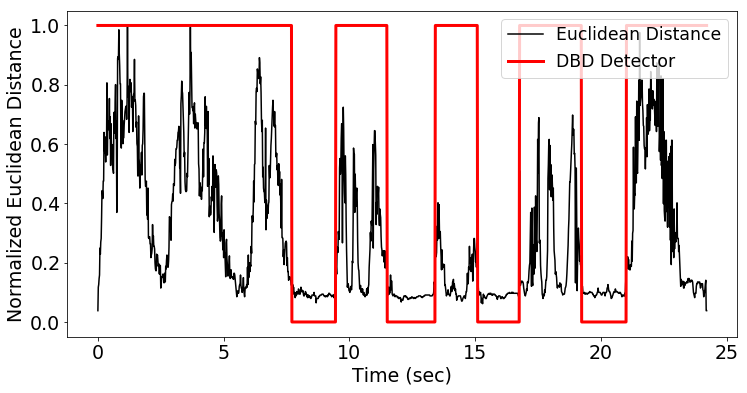

In [6]:
timevec = np.linspace(0,24.2,mask_train_raw.shape[1])
idx = 3
plt.plot(timevec,imit_env_test[idx]/max(imit_env_test[idx]),color='black')
plt.plot(timevec,mask_test[idx],linewidth=3,color='red')
plt.legend(['Euclidean Distance','DBD Detector'], loc = 'upper right', fontsize = 'xx-large')
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.xlabel('Time (sec)',fontsize=19, fontname='Comic Sans MS')
plt.ylabel('Normalized Euclidean Distance',fontsize=19)
# plt.savefig(str(idx)+' dbd gesture detect.png',dpi=400)

In [7]:
def gesture_counter(mask):
    cnt = 0
    flag = 0
    for i in range(len(mask)):
        if flag == 0 and mask[i] == 0:
            continue
        if flag == 1 and mask[i] == 1:
            continue
        if flag == 0 and mask[i] == 1:
            flag = 1
            cnt += 1
        if flag == 1 and mask[i] == 0:
            flag = 0
    return cnt

In [8]:
numgest = [gesture_counter(m) for m in mask_test]
sum(numgest)

685

In [9]:
num_class = 19

In [10]:
def masker(x, y, mask):
    x2 = []
    y2 = []
    flag = 0
    for i in range(len(mask)):
        for j in range(mask.shape[1]):
            if flag == 0 and mask[i,j] == 0:
                continue
            if flag == 1 and mask[i,j] == 1:
                if j == mask.shape[1]-1 and j+1 - startpt > 2:
                    stoppt = j+1
                    x2.append(x[i,startpt:stoppt])
                    y2.append(y[i,startpt:stoppt])
                else:
                    continue
            if flag == 0 and mask[i,j] == 1:
                flag = 1
                startpt = j
            if flag == 1 and mask[i,j] == 0:
                flag = 0
                stoppt = j+1
                if stoppt-startpt > 2:
                    x2.append(x[i,startpt:stoppt])
                    y2.append(y[i,startpt:stoppt])
    
    x2 = np.asarray(x2)
    y2 = np.array([to_categorical(y,num_classes=num_class) for y in np.array(y2)])
    return x2, y2

In [11]:
def down_mask(mask, des_len):
    return np.array([mask[int(len(mask)/des_len*i)] for i in range(des_len)])

In [12]:
des_len = imit_train_images.shape[1]
mask_down_train = np.array([down_mask(mask, des_len) for mask in mask_train])
mask_down_test = np.array([down_mask(mask, des_len) for mask in mask_test])
y_down_train = np.array([down_mask(y, des_len) for y in imit_y_train])
y_down_test = np.array([down_mask(y, des_len) for y in imit_y_test])
y_down_train_cat = to_categorical(y_down_train, num_classes=num_class)
y_down_test_cat = to_categorical(y_down_test, num_classes=num_class)
print(mask_down_train.shape)
print(mask_down_test.shape)
print(y_down_train.shape)
print(y_down_test.shape)
print(y_down_train_cat.shape)
print(y_down_test_cat.shape)

(800, 120)
(200, 120)
(800, 120, 19)
(200, 120, 19)
(800, 120, 19, 19)
(200, 120, 19, 19)


# Gesture detector accuracy

In [13]:
print(mask_down_train.shape)
mask_y = np.argmax(y_down_train,-1) == 0
print(mask_y.shape)
cmp = mask_y != mask_down_train
print(cmp.shape)
acc = np.sum(cmp)/(cmp.shape[0]*cmp.shape[1])*100
print(acc)

(800, 120)
(800, 120)
(800, 120)
84.17916666666667


In [14]:
# thresholds = np.linspace(1,255,255)
# acc_ls = []
# for j,v in enumerate(thresholds):
#     mask_train = dbd(mask_train_raw,v,fill_gap)
#     mask_down_train = np.array([down_mask(mask, des_len) for mask in mask_train])
#     cmp = mask_y != mask_down_train
#     acc = np.sum(cmp)/(cmp.shape[0]*cmp.shape[1])*100
#     acc_ls.append(acc)
#     print(j+1,'. Threshold:',thresholds[j],', acc:',acc)

In [17]:
# plt.figure(figsize=(6,3),dpi=300)
# plt.plot(thresholds,acc_ls,color='b',label='DBD detector')
# plt.xlabel('Threshold')
# plt.ylabel('Detection Accuracy (%)')
# plt.hlines(83.2,0,thresholds[-1],'r',label='Proposed varying length STA/LTA')
# plt.legend(loc='lower right')
# plt.savefig('results/dbd compare.png')

In [18]:
x3train, y3train = masker(imit_train_images, np.argmax(y_down_train,-1), mask_down_train)
x3test, y3test = masker(imit_test_images, np.argmax(y_down_test,-1), mask_down_test) 
print(x3train.shape)
print(y3train.shape)
print(x3test.shape)
print(y3test.shape)

(2105,)
(2105,)
(515,)
(515,)


In [19]:
y3train[0].shape

(59, 19)

In [20]:
classes = [stats.mode(np.argmax(y,-1))[0] for y in y3train]
c = [int(x) for x in classes]
Counter(c)

Counter({1: 115,
         11: 122,
         12: 125,
         3: 645,
         5: 124,
         6: 130,
         17: 103,
         18: 111,
         8: 125,
         9: 128,
         0: 116,
         4: 13,
         14: 91,
         15: 90,
         16: 18,
         10: 19,
         13: 7,
         7: 11,
         2: 12})

In [21]:
# eliminate zeros md
x6train = np.array([x3train[i] for i in range(len(y3train)) if stats.mode(np.argmax(y3train[i],-1))[0] != 0])
y6train = np.array([y3train[i] for i in range(len(y3train)) if stats.mode(np.argmax(y3train[i],-1))[0] != 0])
x6test = np.array([x3test[i] for i in range(len(y3test)) if stats.mode(np.argmax(y3test[i],-1))[0] != 0])
y6test = np.array([y3test[i] for i in range(len(y3test)) if stats.mode(np.argmax(y3test[i],-1))[0] != 0])
print(x6train.shape)
print(y6train.shape)
print(x6test.shape)
print(y6test.shape)

(1989,)
(1989,)
(489,)
(489,)


## RD - RA

In [22]:
# filename = 'Datasets/final_imit_RD-RA2.pkl'
# with open(filename, 'rb') as input:
#     x = pickle.load(input)
# imit_y_train_RD, imit_y_test_RD, imit_RD_train, imit_RA_train, imit_RD_test, imit_RA_test = [x[0], x[1]
#                                                                                                 , x[2], x[3]
#                                                                                                 , x[4], x[5]]
# print(imit_y_train_RD.shape)
# print(imit_y_test_RD.shape)
# print(imit_RD_train.shape)
# print(imit_RA_train.shape)
# print(imit_RD_test.shape)
# print(imit_RA_test.shape)
# del x

In [23]:
filename = 'Datasets/final_imit_RD-RA2_128_last.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
imit_RD_train = np.array(data["train_RD"])
imit_RA_train = np.array(data["train_RA"])
imit_RD_test = np.array(data["test_RD"])
imit_RA_test = np.array(data["test_RA"])
data.close()
print(imit_RD_train.shape)
print(imit_RA_train.shape)
print(imit_RD_test.shape)
print(imit_RA_test.shape)

Selected File: Datasets/final_imit_RD-RA2_128_last.hdf5
(800, 605, 128, 128, 3)
(800, 605, 128, 128, 3)
(200, 605, 128, 128, 3)
(200, 605, 128, 128, 3)


In [24]:
# windowed RD
interval = range(0,600)
x_train11 = np.reshape(imit_RD_train[:,interval,:,:,:], (imit_RD_train.shape[0],120,5,imit_RD_train.shape[2],imit_RD_train.shape[3],imit_RD_train.shape[4]))
x_test11 = np.reshape(imit_RD_test[:,interval,:,:,:], (imit_RD_test.shape[0],120,5,imit_RD_test.shape[2],imit_RD_test.shape[3],imit_RD_test.shape[4]))
# y_train11 = np.reshape(imit_y_train_RD[:,interval], (imit_y_train_RD.shape[0],120,5))
# y_test11 = np.reshape(imit_y_test_RD[:,interval], (imit_y_test_RD.shape[0],120,5))
# y_train11 = to_categorical(np.squeeze(stats.mode(y_train11,2)[0]))
# y_test11 = to_categorical(np.squeeze(stats.mode(y_test11,2)[0]))
print(x_train11.shape)
# print(y_train11.shape)
print(x_test11.shape)
# print(y_test11.shape)  

# windowed RA
x_train12 = np.reshape(imit_RA_train[:,interval,:,:,:], (imit_RA_train.shape[0],120,5,imit_RA_train.shape[2],imit_RA_train.shape[3],imit_RA_train.shape[4]))
x_test12 = np.reshape(imit_RA_test[:,interval,:,:,:], (imit_RA_test.shape[0],120,5,imit_RA_test.shape[2],imit_RA_test.shape[3],imit_RA_test.shape[4]))
print(x_train12.shape)
print(x_test12.shape)

(800, 120, 5, 128, 128, 3)
(200, 120, 5, 128, 128, 3)
(800, 120, 5, 128, 128, 3)
(200, 120, 5, 128, 128, 3)


In [25]:
# x1train, y1train = masker(x_train11, np.argmax(y_train11,-1), mask_down_train)
# x1test, y1test = masker(x_test11, np.argmax(y_test11,-1), mask_down_test)
# x2train, y1train = masker(x_train12, np.argmax(y_train11,-1), mask_down_train)
# x2test, y1test = masker(x_test12, np.argmax(y_test11,-1), mask_down_test)
x1train, y1train = masker(x_train11, y_down_train, mask_down_train)
x1test, y1test = masker(x_test11, y_down_test, mask_down_test)
x2train, y1train = masker(x_train12, y_down_train, mask_down_train)
x2test, y1test = masker(x_test12, y_down_test, mask_down_test)
print(x1train.shape)
print(y1train.shape)
print(x1test.shape)
print(y1test.shape)
print(x2train.shape)
print(x2test.shape)

(2105,)
(2105,)
(515,)
(515,)
(2105,)
(515,)


In [26]:
x10train = np.array([x1train[i] for i in range(len(y3train)) if stats.mode(np.argmax(y3train[i],-1))[0] != 0])
x11train = np.array([x2train[i] for i in range(len(y3train)) if stats.mode(np.argmax(y3train[i],-1))[0] != 0])
# y10train = np.array([y1train[i] for i in range(len(y3train)) if stats.mode(np.argmax(y3train[i],-1))[0] != 0])
x10test = np.array([x1test[i] for i in range(len(y3test)) if stats.mode(np.argmax(y3test[i],-1))[0] != 0])
x11test = np.array([x2test[i] for i in range(len(y3test)) if stats.mode(np.argmax(y3test[i],-1))[0] != 0])
# y10test = np.array([y1test[i] for i in range(len(y3test)) if stats.mode(np.argmax(y3test[i],-1))[0] != 0])
print(x10train.shape)
# print(y10train.shape)
print(x10test.shape)
# print(y10test.shape)
print(x11train.shape)
print(x11test.shape)

(1989,)
(489,)
(1989,)
(489,)


In [27]:
x12train = np.array([x.reshape(x.shape[0]*x.shape[1],x.shape[2],x.shape[3],x.shape[4]) for x in x10train])
x13train = np.array([x.reshape(x.shape[0]*x.shape[1],x.shape[2],x.shape[3],x.shape[4]) for x in x11train])
x12test = np.array([x.reshape(x.shape[0]*x.shape[1],x.shape[2],x.shape[3],x.shape[4]) for x in x10test])
x13test = np.array([x.reshape(x.shape[0]*x.shape[1],x.shape[2],x.shape[3],x.shape[4]) for x in x11test])
print(x12train[0].shape)
print(x12test[0].shape)
print(x13train.shape)
print(x13test.shape)

(295, 128, 128, 3)
(235, 128, 128, 3)
(1989,)
(489,)


In [28]:
input_shape_vid = (None, x_train11[0].shape[1],x_train11[0].shape[2],x_train11[0].shape[3],x_train11[0].shape[4])
print('Input shape of f-b-f RD: ',input_shape_vid)

Input shape of f-b-f RD:  (None, 5, 128, 128, 3)


In [29]:
input_shape11 = (None,x3train[0].shape[1],x3train[0].shape[2],x3train[0].shape[3])
print('Input shape of f-b-f mD: ',input_shape11)

Input shape of f-b-f mD:  (None, 128, 128, 3)


In [30]:
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=early_stopping_patience, restore_best_weights=True
)

In [31]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor=0.5, patience=0, verbose=0)

In [32]:
gc.collect()

269

In [33]:
ytrain = np.array([np.squeeze(to_categorical(stats.mode(np.argmax(y3train[i],-1))[0],19)) for i in tqdm(range(len(y3train)), position = 0, leave = True) if stats.mode(np.argmax(y3train[i],-1))[0] != 0])
ytest = np.array([np.squeeze(to_categorical(stats.mode(np.argmax(y3test[i],-1))[0],19)) for i in tqdm(range(len(y3test)), position = 0, leave = True) if stats.mode(np.argmax(y3test[i],-1))[0] != 0])
print(ytrain.shape)
print(ytest.shape)

100%|██████████| 515/515 [00:00<00:00, 3363.92it/s]

(1989, 19)
(489, 19)


In [34]:
def mode_finder(y): # finds the mode that is not zero
    y = np.argmax(y,-1)
    mode = stats.mode(y)[0]
    if mode == 0:
        mask = y == mode
        y = y[~np.ma.masked_array(y, mask = mask).mask]
        new_mode = stats.mode(y)[0]
    else:
        new_mode = mode
    return np.squeeze(new_mode)

# CTC

In [35]:
y_int_train = np.array([np.argmax(y,-1) for y in y6train])
y_int_test = np.array([np.argmax(y,-1) for y in y6test])

In [36]:
y_asldaily_tr = [] # 0: daily, 1: asl
y_twohanded_tr = [] # 0: daily, 1: 1 hand, 2: 2 hand
y_loc_tr = [] # major location: 0: daily, 1: body, 2: neutral, 3: head, 4: hand
y_mov_tr = [] # movement: 0: daily, 1: curved, 2: straight, 3: backandforth, 4: circular, 5: other
y_str_tr = [] # # of strokes: 0: daily, 1: 3, 2: 4, 3: +5

y_asldaily_ts = [] # 0: daily, 1: asl
y_twohanded_ts = [] # 0: daily, 1: 1 hand, 2: 2 hand
y_loc_ts = [] # major location: 0: daily, 1: body, 2: neutral, 3: head, 4: hand
y_mov_ts = [] # movement: 0: daily, 1: curved, 2: straight, 3: backandforth, 4: circular, 5: other
y_str_ts = [] # # of strokes: 0: daily, 1: 3, 2: 4, 3: +5

## asl daily
for i in range(len(y_int_train)):
    yx = np.zeros(shape=y_int_train[i].shape)
    for j in range(len(y_int_train[i])):
        if y_int_train[i][j] in (0,1,2,3):
            continue
        else:
            yx[j] = 1
    y_asldaily_tr.append(to_categorical(yx,2))
for i in range(len(y_int_test)):
    yx = np.zeros(shape=y_int_test[i].shape)
    for j in range(len(y_int_test[i])):
        if y_int_test[i][j] in (0,1,2,3):
            continue
        else:
            yx[j] = 1
    y_asldaily_ts.append(to_categorical(yx,2))
    
## two hand
for i in range(len(y_int_train)):
    yx = np.zeros(shape=y_int_train[i].shape)
    for j in range(len(y_int_train[i])):
        if y_int_train[i][j] in (0,1,2,3):
            continue
        elif y_int_train[i][j] in (9,16):
            yx[j] = 1
        else:
            yx[j] = 2
    y_twohanded_tr.append(to_categorical(yx,3))
for i in range(len(y_int_test)):
    yx = np.zeros(shape=y_int_test[i].shape)
    for j in range(len(y_int_test[i])):
        if y_int_test[i][j] in (0,1,2,3):
            continue
        elif y_int_test[i][j] in (9,16):
            yx[j] = 1
        else:
            yx[j] = 2
    y_twohanded_ts.append(to_categorical(yx,3))

## hand loc
for i in range(len(y_int_train)):
    yx = np.zeros(shape=y_int_train[i].shape)
    for j in range(len(y_int_train[i])):
        if y_int_train[i][j] in (0,1,2,3):
            continue
        elif y_int_train[i][j] == 4:
            yx[j] = 1
        elif y_int_train[i][j] in (5,8,14,16):
            yx[j] = 2
        elif y_int_train[i][j] in (6,9,17,18):
            yx[j] = 3
        else:
            yx[j] = 4
    y_loc_tr.append(to_categorical(yx,5))
for i in range(len(y_int_test)):
    yx = np.zeros(shape=y_int_test[i].shape)
    for j in range(len(y_int_test[i])):
        if y_int_test[i][j] in (0,1,2,3):
            continue
        elif y_int_test[i][j] == 4:
            yx[j] = 1
        elif y_int_test[i][j] in (5,8,14,16):
            yx[j] = 2
        elif y_int_test[i][j] in (6,9,17,18):
            yx[j] = 3
        else:
            yx[j] = 4
    y_loc_ts.append(to_categorical(yx,5))

## movement type
for i in range(len(y_int_train)):
    yx = np.zeros(shape=y_int_train[i].shape)
    for j in range(len(y_int_train[i])):
        if y_int_train[i][j] in (0,1,2,3):
            continue
        elif y_int_train[i][j] in (4,5,9,12):
            yx[j] = 1
        elif y_int_train[i][j] in (6,7,8,10,14,15,17,18):
            yx[j] = 2
        elif y_int_train[i][j] == 13:
            yx[j] = 3
        elif y_int_train[i][j] == 16:
            yx[j] = 4
        else:
            yx[j] = 5
    y_mov_tr.append(to_categorical(yx,6))
for i in range(len(y_int_test)):
    yx = np.zeros(shape=y_int_test[i].shape)
    for j in range(len(y_int_test[i])):
        if y_int_test[i][j] in (0,1,2,3):
            continue
        elif y_int_test[i][j] in (4,5,9,12):
            yx[j] = 1
        elif y_int_test[i][j] in (6,7,8,10,14,15,17,18):
            yx[j] = 2
        elif y_int_test[i][j] == 13:
            yx[j] = 3
        elif y_int_test[i][j] == 16:
            yx[j] = 4
        else:
            yx[j] = 5
    y_mov_ts.append(to_categorical(yx,6))
    
## # of strokes
for i in range(len(y_int_train)):
    yx = np.zeros(shape=y_int_train[i].shape)
    for j in range(len(y_int_train[i])):
        if y_int_train[i][j] in (0,1,2,3):
            continue
        elif y_int_train[i][j] in (4,5,9,10,13,15,18):
            yx[j] = 1
        elif y_int_train[i][j] in (6,8,12,16,17):
            yx[j] = 2
        else:
            yx[j] = 3
    y_str_tr.append(to_categorical(yx,4))
for i in range(len(y_int_test)):
    yx = np.zeros(shape=y_int_test[i].shape)
    for j in range(len(y_int_test[i])):
        if y_int_test[i][j] in (0,1,2,3):
            continue
        elif y_int_test[i][j] in (4,5,9,10,13,15,18):
            yx[j] = 1
        elif y_int_test[i][j] in (6,8,12,16,17):
            yx[j] = 2
        else:
            yx[j] = 3
    y_str_ts.append(to_categorical(yx,4))

In [37]:
def num_to_ch(num):
    label = ''
    for ch in num:
        label += chr(ord('@') + np.argmax(ch,-1)+1)
    return label

In [38]:
# convert detected labels
ctc_tr3 = [num_to_ch(y) for y in y6train]
ctc_ts3 = [num_to_ch(y) for y in y6test]
print(ctc_tr3[0])
# ctc_tr1 = [num_to_ch(y) for y in y10train]
# ctc_ts1 = [num_to_ch(y) for y in y10test]
# print(ctc_tr1[0])

ABBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBCCCCCCCCCCAAAKKKKKKKKKKKAA


In [39]:
# convert detected labels
ctc_tr4 = [num_to_ch(to_categorical(stats.mode(np.argmax(y,-1))[0],num_classes=num_class))*len(y) for y in y6train]
ctc_ts4 = [num_to_ch(to_categorical(stats.mode(np.argmax(y,-1))[0],num_classes=num_class))*len(y) for y in y6test]
# ctc_tr4 = [num_to_ch(to_categorical(stats.mode(np.argmax(y,-1))[0],num_classes=num_class)) for y in y6train]
# ctc_ts4 = [num_to_ch(to_categorical(stats.mode(np.argmax(y,-1))[0],num_classes=num_class)) for y in y6test]
print(ctc_tr4[0])
# ctc_tr2 = [num_to_ch(to_categorical(stats.mode(np.argmax(y,-1))[0],num_classes=num_class))*len(y) for y in y10train]
# ctc_ts2 = [num_to_ch(to_categorical(stats.mode(np.argmax(y,-1))[0],num_classes=num_class))*len(y) for y in y10test]
# # ctc_tr2 = [num_to_ch(to_categorical(stats.mode(np.argmax(y,-1))[0],num_classes=num_class)) for y in y10train]
# # ctc_ts2 = [num_to_ch(to_categorical(stats.mode(np.argmax(y,-1))[0],num_classes=num_class)) for y in y10test]
# print(ctc_tr2[0])

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB


In [40]:
characters3 = set(char for label in ctc_tr3 for char in label)
print("Number of unique characters: ", len(characters3))
print("Characters present: ", sorted(characters3))
# print('Labels: ' + str(np.unique(ctc_tr3)))
batch_size = 1

Number of unique characters:  19
Characters present:  ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S']


In [41]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True)

In [42]:
class CTCLayer(Layer):
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred          

# CTC + MTL

In [43]:
def data_generator_mtl(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            label = labels[0][offset:offset+batch_size]
            asldaily = labels[1][offset:offset+batch_size]
            twohand = labels[2][offset:offset+batch_size]
            major = labels[3][offset:offset+batch_size]
            move = labels[4][offset:offset+batch_size]
            stroke = labels[5][offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            y_train = []
            y_train2 = []
            y_train3 = []
            y_train4 = []
            y_train5 = []
            y_train6 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                y_train.append(np.array([ord(y)%32 for y in label[i]]))
#                 y_train.append(label[i])
                y_train2.append(asldaily[i])
                y_train3.append(twohand[i])
                y_train4.append(major[i])
                y_train5.append(move[i])
                y_train6.append(stroke[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)
            y_train2 = np.array(y_train2)
            y_train3 = np.array(y_train3)
            y_train4 = np.array(y_train4)
            y_train5 = np.array(y_train5)
            y_train6 = np.array(y_train6)
            
            # yield the next training batch            
            yield [X_train3, y_train], [y_train, y_train2, y_train3, y_train4, y_train5, y_train6]
#             yield [X_train3, y_train], y_train

In [44]:
def data_generator_mtl_nolabel(data, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            
            # yield the next training batch            
            yield [X_train3]

### mD

In [45]:
train_dataset = data_generator_mtl([x12train, x13train, x6train], 
                                     [ctc_tr3, y_asldaily_tr, y_twohanded_tr, y_loc_tr, y_mov_tr, y_str_tr])
validation_dataset = data_generator_mtl([x12test, x13test, x6test], 
                                     [ctc_ts3, y_asldaily_ts, y_twohanded_ts, y_loc_ts, y_mov_ts, y_str_ts])
predict_generator = data_generator_mtl_nolabel([x12test, x13test, x6test])

In [46]:
def ctc_md_mtl():
    with tf.device('/gpu:2'):
        
        inputlayer = Input(shape = input_shape11, name="image")
        labels = Input(name="label", shape=(None,))#, dtype="float32")
        
        x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = BatchNormalization()(x)
        x = TimeDistributed(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = BatchNormalization()(x)
        x = TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = BatchNormalization()(x)
        x = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         new_shape = (-1, 64*8*8//2)
        
        new_shape = (-1, (128//2**3) *64)
#         new_shape = (-1, 16*16*64//2)
#         new_shape = (-1, 16*16*16//8) ## keeping time dim long increases the training time
        
        cnv1 = Reshape(target_shape=new_shape)(x)
        cnv1 = Dense(64, activation="relu")(cnv1)
        cnv1 = Dropout(0.5)(cnv1)
        cnv1 = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(cnv1)
#         cnv1 = Dropout(0.5)(cnv1)
#         cnv1 = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(cnv1)
    
        x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(cnv1)
        out_ctc = CTCLayer(name="ctc_loss")(labels, x2)
        
        aux_pool = MaxPooling1D(pool_size=(2**2), name='aux_pool')(cnv1)
        out_asldaily = TimeDistributed(Dense(2, activation='softmax'), name="asldaily")(aux_pool)
        out_twohanded = TimeDistributed(Dense(3, activation='softmax'), name="twohanded")(aux_pool)
        out_major = TimeDistributed(Dense(5, activation='softmax'), name="major")(aux_pool)
        out_movement = TimeDistributed(Dense(6, activation='softmax'), name="movement")(aux_pool)
        out_stroke = TimeDistributed(Dense(4, activation='softmax'), name="stroke")(aux_pool)
        
        model = keras.Model(inputs = [inputlayer, labels], 
                            outputs = [out_ctc, out_asldaily, out_twohanded, out_major, out_movement, out_stroke], 
                           name="ctc_model")
        opt = Adam(lr=2e-4, decay=1e-3 / 200)
        model.compile(optimizer=opt, loss_weights = [1,0.2,0.2,0.2,0.2,0.2])
        
        return model

In [47]:
model = ctc_md_mtl()

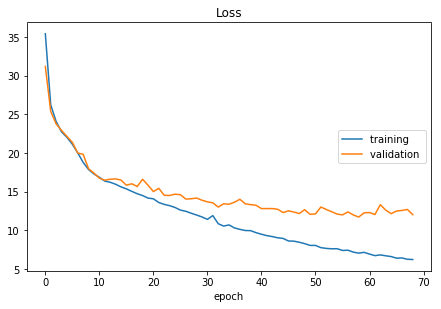

Loss
	training         	 (min:    6.232, max:   35.422, cur:    6.232)
	validation       	 (min:   11.723, max:   31.210, cur:   12.036)
1989/1989 [==============================] - 41s 21ms/step - loss: 6.2322 - val_loss: 12.0361


In [48]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(y6train), validation_steps = len(y6test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [49]:
# save model
fname = 'revision dbd mti ctc mtl md gd'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [50]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
# prediction_model.summary()

In [51]:
pred = [np.argmax(np.squeeze(prediction_model.predict(next(predict_generator))),-1) for i in range(len(x6test))]

In [52]:
# best path decoding
pred_labels = []

cnt = 1
for p in pred:
    label = ''
    for num in p:
        if chr(ord('@')+num) == 'T':# or chr(ord('@')+num) == 'A':
            continue
        label = label + chr(ord('@')+num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels)  
print(pred_labels[2])

MMMMMMMMMMMA


In [53]:
for idx in range(len(ctc_ts3)):
#     print(idx)
#     if max(Counter(pred_labels[idx]), key=Counter(pred_labels[idx]).get) != max(Counter(ctc_ts3[idx]), key=Counter(ctc_ts3[idx]).get):
    print(str(idx+1) + '. Predicted: ' + pred_labels[idx] + ' | ' + ctc_ts3[idx] + ' :Original')

1. Predicted: BBBBBBBBBBBBBBBBBBBBBCCCCCCCCCCCCCCCCCCAAAAAAHHHHHHHHEAAAAA | BBBBBBBBBBBBBBBBBCCCCCCCCCCAAAAAAKKKKKKKKKKKKKA :Original
2. Predicted: LLLLLLLLA | LLLLLLLLLA :Original
3. Predicted: MMMMMMMMMMMA | MMMMMMMMMAA :Original
4. Predicted: DDDDDDDDDDDD | DDDDDDDD :Original
5. Predicted: FFFFFFFFFFA | FFFFFFFFFFA :Original
6. Predicted: GGGGGGGGGGA | GGGGGGGGGGA :Original
7. Predicted: DDDDDDDDDDD | DDDDDDD :Original
8. Predicted: LLLLLLLLLLA | LLLLLLLLLLA :Original
9. Predicted: MMMMMMMMMMMMMA | MMMMMMMMAAA :Original
10. Predicted: DDDDDDDDDDDDA | DDDDDDDDDAA :Original
11. Predicted: KKKQQKKHHHHAA | EEEEEEEEEEEA :Original
12. Predicted: FFFFFFFFF | FFFFFFFFF :Original
13. Predicted: GGGGGGGGGGGGA | GGGGGGGGGGGAA :Original
14. Predicted: DDDDDDDDDDAAAAAA | DDDDDDDDDDAAAAA :Original
15. Predicted: FFFFFFFFFA | FFFFFFFFFF :Original
16. Predicted: GGGGGGGGGGGA | GGGGGGGGGGA :Original
17. Predicted: DDDDDDDDDDDD | DDDDDDDD :Original
18. Predicted: BBBBBBBBBBBBBBBBBBCCCCCCCCCCCCCCAAAQQ

In [54]:
from collections import Counter
mode_orig = [max(Counter(y), key=Counter(y).get) for y in ctc_ts3]
mode_pred = [max(Counter(y), key=Counter(y).get) if len(y) != 0 else 'A' for y in pred_labels]

In [55]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts3)) if len(mode_pred[i]) != 0]
# cmp = ctc_ts4 == pred_labels
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc # was 71 with 8 16 32 64, 77 with 8 16 32 64 64, 74 with 8 16 32 64 64 64

74.02862985685071

In [56]:
ctc_pred = np.array([mode_pred[i]*len(ctc_ts3[i]) for i in range(len(ctc_ts4))])
# ctc_pred = pred_labels
cmp = [ctc_pred[i][j] == ctc_ts3[i][j] for i in range(len(ctc_ts4)) for j in range(len(ctc_ts4[i]))]
new_acc = np.sum(cmp)/len(cmp)*100
new_acc # 80.4 w ctc4

56.04765241765942

### RD

In [57]:
def ctc_rd_mtl():
    with tf.device('/gpu:2'):
        
        inputlayer = Input(shape = input_shape_vid, name="rd")
        labels = Input(name="label", shape=(None,))#, dtype="float32")
        
        x = TimeDistributed(Conv3D(32, kernel_size=(3, 3, 3), padding='same', activation='relu'))(inputlayer)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(Conv3D(64, kernel_size=(3, 3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(Conv3D(64, kernel_size=(3, 3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,4,1)))(x)
        
        new_shape = (-1, (128//2**3)*64*5)
#         new_shape = (-1, 8*8*64)
#         new_shape = (-1, (64//2**3)*5*8)
        cnv1 = Reshape(target_shape=new_shape)(x)
        cnv1 = Dense(64, activation="relu")(cnv1)
        cnv1 = Dropout(0.5)(cnv1)
        cnv1 = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(cnv1)
    
        x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(cnv1)
        out_ctc = CTCLayer(name="ctc_loss")(labels, x2)
        
        aux_pool = MaxPooling1D(pool_size=(2**2), name='aux_pool')(cnv1)
        
        out_asldaily = TimeDistributed(Dense(2, activation='softmax'), name="asldaily")(aux_pool)
        out_twohanded = TimeDistributed(Dense(3, activation='softmax'), name="twohanded")(aux_pool)
        out_major = TimeDistributed(Dense(5, activation='softmax'), name="major")(aux_pool)
        out_movement = TimeDistributed(Dense(6, activation='softmax'), name="movement")(aux_pool)
        out_stroke = TimeDistributed(Dense(4, activation='softmax'), name="stroke")(aux_pool)
        
        model = keras.Model(inputs = [inputlayer, labels], 
                            outputs = [out_ctc, out_asldaily, out_twohanded, out_major, out_movement, out_stroke], 
                           name="ctc_model")
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        model.compile(optimizer=opt, loss_weights = [1,0.2,0.2,0.2,0.2,0.2])
        
        return model

In [58]:
def ctc_rd_mtl2():
    with tf.device('/gpu:2'):
        
        inputlayer = Input(shape = input_shape11, name="rd")
        labels = Input(name="label", shape=(None,))#, dtype="float32")
        
        x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = BatchNormalization()(x)
        x = TimeDistributed(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = BatchNormalization()(x)
        x = TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = BatchNormalization()(x)
        x = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        new_shape = (-1, 64*8*8*5//2)
        
#         new_shape = (-1, (128//2**3) *64*5)
#         new_shape = (-1, 16*16*64//2)
#         new_shape = (-1, 16*16*16//8) ## keeping time dim long increases the training time
        
        cnv1 = Reshape(target_shape=new_shape)(x)
#         cnv1 = Dense(64, activation="relu")(cnv1)
#         cnv1 = Dropout(0.5)(cnv1)
        cnv1 = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(cnv1)
#         cnv1 = Dropout(0.5)(cnv1)
#         cnv1 = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(cnv1)
    
        x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(cnv1)
        out_ctc = CTCLayer(name="ctc_loss")(labels, x2)
        
        out_asldaily = TimeDistributed(Dense(2, activation='softmax'), name="asldaily")(cnv1)
        out_twohanded = TimeDistributed(Dense(3, activation='softmax'), name="twohanded")(cnv1)
        out_major = TimeDistributed(Dense(5, activation='softmax'), name="major")(cnv1)
        out_movement = TimeDistributed(Dense(6, activation='softmax'), name="movement")(cnv1)
        out_stroke = TimeDistributed(Dense(4, activation='softmax'), name="stroke")(cnv1)
        
        model = keras.Model(inputs = [inputlayer, labels], 
                            outputs = [out_ctc, out_asldaily, out_twohanded, out_major, out_movement, out_stroke], 
                           name="ctc_model")
        opt = Adam(lr=2e-4, decay=1e-3 / 200)
        model.compile(optimizer=opt, loss_weights = [1,0.2,0.2,0.2,0.2,0.2])
        
        return model

In [59]:
train_dataset = data_generator_mtl([x6train, x11train, x10train], 
                                     [ctc_tr3, y_asldaily_tr, y_twohanded_tr, y_loc_tr, y_mov_tr, y_str_tr])
validation_dataset = data_generator_mtl([x6test, x11test, x10test], 
                                     [ctc_ts3, y_asldaily_ts, y_twohanded_ts, y_loc_ts, y_mov_ts, y_str_ts])
predict_generator = data_generator_mtl_nolabel([x6test, x11test, x10test])

In [60]:
model = ctc_rd_mtl()

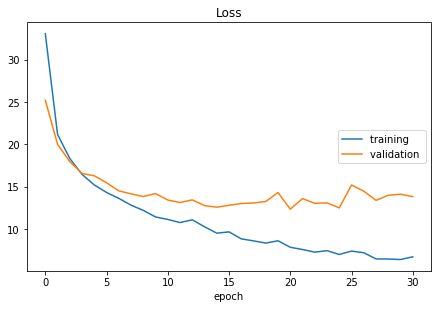

Loss
	training         	 (min:    6.232, max:   35.422, cur:    6.720)
	validation       	 (min:   11.723, max:   31.210, cur:   13.822)
1989/1989 [==============================] - 108s 54ms/step - loss: 6.7197 - val_loss: 13.8221


In [61]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x10train), validation_steps = len(x10test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [62]:
# save model
fname = 'revision dbd mti ctc mtl rd gd'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [63]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="rd").input, model.get_layer(name="dense2").output
)
# prediction_model.summary()

In [64]:
pred = [np.argmax(np.squeeze(prediction_model.predict(next(predict_generator))),-1) for i in range(len(x10test))]

In [65]:
# best path decoding
pred_labels = []

cnt = 1
for p in pred:
    label = ''
    for num in p:
        if chr(ord('@')+num) == 'T':# or chr(ord('@')+num) == 'A':
            continue
        label = label + chr(ord('@')+num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels)  
print(pred_labels[2])

FFFFFFFFLLA


In [66]:
for idx in range(len(ctc_ts3)):
#     print(idx)
#     if max(Counter(pred_labels[idx]), key=Counter(pred_labels[idx]).get) != max(Counter(ctc_ts3[idx]), key=Counter(ctc_ts3[idx]).get):
    print(str(idx+1) + '. Predicted: ' + pred_labels[idx] + ' | ' + ctc_ts3[idx] + ' :Original')

1. Predicted: BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBCCCCCCCCCCCCCCCCCCCCCAAAAAAAAAAAAAAAKKKKKKKKKKKKKKK | BBBBBBBBBBBBBBBBBCCCCCCCCCCAAAAAAKKKKKKKKKKKKKA :Original
2. Predicted: LLLLLLLLLA | LLLLLLLLLA :Original
3. Predicted: FFFFFFFFLLA | MMMMMMMMMAA :Original
4. Predicted: DDDDDDDDDDDDDDDDDDD | DDDDDDDD :Original
5. Predicted: FFFFFFFFFFA | FFFFFFFFFFA :Original
6. Predicted: GGGGGGGGGGGGA | GGGGGGGGGGA :Original
7. Predicted: DDDDDDDDDDDDDDDDDD | DDDDDDD :Original
8. Predicted: FFFFFFFFFFFFA | LLLLLLLLLLA :Original
9. Predicted: FFFFFFFFFF | MMMMMMMMAAA :Original
10. Predicted: DDDDDDDDDDDDDDDDDDDA | DDDDDDDDDAA :Original
11. Predicted: GGGGGGGGGA | EEEEEEEEEEEA :Original
12. Predicted: FFFFFFFFF | FFFFFFFFF :Original
13. Predicted: GGGGGGGGGGGGA | GGGGGGGGGGGAA :Original
14. Predicted: DDDDDDDDDDDDDDDDDDDDDDDDDDDA | DDDDDDDDDDAAAAA :Original
15. Predicted: FFFFFFLLLLA | FFFFFFFFFF :Original
16. Predicted: GGGGGGGGGGGA | GGGGGGGGGGA :Original
17. Predicted: DDDDDDDDDDDDDDDDDDDD | DDDDDDDD 

In [67]:
from collections import Counter
mode_orig = [max(Counter(y), key=Counter(y).get) for y in ctc_ts3]
mode_pred = [max(Counter(y), key=Counter(y).get) if len(y) != 0 else 'A' for y in pred_labels]

In [68]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts3)) if len(mode_pred[i]) != 0]
# cmp = ctc_ts4 == pred_labels
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc # was 71 with 8 16 32 64, 77 with 8 16 32 64 64, 74 with 8 16 32 64 64 64

68.09815950920245

In [69]:
ctc_pred = np.array([mode_pred[i]*len(ctc_ts3[i]) for i in range(len(ctc_ts4))])
# ctc_pred = pred_labels
cmp = [ctc_pred[i][j] == ctc_ts3[i][j] for i in range(len(ctc_ts4)) for j in range(len(ctc_ts4[i]))]
new_acc = np.sum(cmp)/len(cmp)*100
new_acc # 80.4 w ctc4

51.89908899789769

### RA

In [70]:
train_dataset = data_generator_mtl([x6train, x10train, x11train], 
                                     [ctc_tr3, y_asldaily_tr, y_twohanded_tr, y_loc_tr, y_mov_tr, y_str_tr])
validation_dataset = data_generator_mtl([x6test, x10test, x11test], 
                                     [ctc_ts3, y_asldaily_ts, y_twohanded_ts, y_loc_ts, y_mov_ts, y_str_ts])
predict_generator = data_generator_mtl_nolabel([x6test, x10test, x11test])

In [71]:
def ctc_ra_mtl():
    with tf.device('/gpu:2'):
        
        inputlayer = Input(shape = input_shape_vid, name="ra")
        labels = Input(name="label", shape=(None,))#, dtype="float32")
        
        x = TimeDistributed(Conv3D(32, kernel_size=(3, 3, 3), padding='same', activation='relu'))(inputlayer)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(Conv3D(64, kernel_size=(3, 3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(Conv3D(64, kernel_size=(3, 3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,4,1)))(x)
        
        new_shape = (-1, (128//2**3)*64*5)
#         new_shape = (-1, 8*8*64)
#         new_shape = (-1, (64//2**3)*5*8)
        cnv1 = Reshape(target_shape=new_shape)(x)
        cnv1 = Dense(64, activation="relu")(cnv1)
        cnv1 = Dropout(0.5)(cnv1)
        cnv1 = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(cnv1)
    
        x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(cnv1)
        out_ctc = CTCLayer(name="ctc_loss")(labels, x2)
        
        aux_pool = MaxPooling1D(pool_size=(2**2), name='aux_pool')(cnv1)
        out_asldaily = TimeDistributed(Dense(2, activation='softmax'), name="asldaily")(aux_pool)
        out_twohanded = TimeDistributed(Dense(3, activation='softmax'), name="twohanded")(aux_pool)
        out_major = TimeDistributed(Dense(5, activation='softmax'), name="major")(aux_pool)
        out_movement = TimeDistributed(Dense(6, activation='softmax'), name="movement")(aux_pool)
        out_stroke = TimeDistributed(Dense(4, activation='softmax'), name="stroke")(aux_pool)
        
        model = keras.Model(inputs = [inputlayer, labels], 
                            outputs = [out_ctc, out_asldaily, out_twohanded, out_major, out_movement, out_stroke], 
                           name="ctc_model")
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        model.compile(optimizer=opt, loss_weights = [1,0.2,0.2,0.2,0.2,0.2])
        
        return model

In [72]:
def ctc_ra_mtl2():
    with tf.device('/gpu:2'):
        
        inputlayer = Input(shape = input_shape11, name="ra")
        labels = Input(name="label", shape=(None,))#, dtype="float32")
        
        x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = BatchNormalization()(x)
        x = TimeDistributed(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = BatchNormalization()(x)
        x = TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = BatchNormalization()(x)
        x = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        new_shape = (-1, 64*8*8*5//2)
        
#         new_shape = (-1, (128//2**3) *64*5)
#         new_shape = (-1, 16*16*64//2)
#         new_shape = (-1, 16*16*16//8) ## keeping time dim long increases the training time
        
        cnv1 = Reshape(target_shape=new_shape)(x)
#         cnv1 = Dense(64, activation="relu")(cnv1)
#         cnv1 = Dropout(0.5)(cnv1)
        cnv1 = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(cnv1)
#         cnv1 = Dropout(0.5)(cnv1)
#         cnv1 = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(cnv1)
    
        x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(cnv1)
        out_ctc = CTCLayer(name="ctc_loss")(labels, x2)
        
        out_asldaily = TimeDistributed(Dense(2, activation='softmax'), name="asldaily")(cnv1)
        out_twohanded = TimeDistributed(Dense(3, activation='softmax'), name="twohanded")(cnv1)
        out_major = TimeDistributed(Dense(5, activation='softmax'), name="major")(cnv1)
        out_movement = TimeDistributed(Dense(6, activation='softmax'), name="movement")(cnv1)
        out_stroke = TimeDistributed(Dense(4, activation='softmax'), name="stroke")(cnv1)
        
        model = keras.Model(inputs = [inputlayer, labels], 
                            outputs = [out_ctc, out_asldaily, out_twohanded, out_major, out_movement, out_stroke], 
                           name="ctc_model")
        opt = Adam(lr=2e-4, decay=1e-3 / 200)
        model.compile(optimizer=opt, loss_weights = [1,0.1,0.1,0.1,0.1,0.1])
        
        return model

In [73]:
model = ctc_ra_mtl()

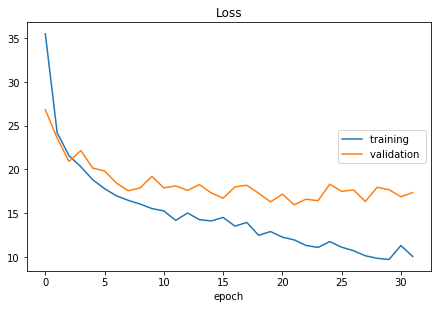

Loss
	training         	 (min:    6.232, max:   35.512, cur:   10.042)
	validation       	 (min:   11.723, max:   31.210, cur:   17.361)
1989/1989 [==============================] - 107s 54ms/step - loss: 10.0418 - val_loss: 17.3613


In [74]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x11train), validation_steps = len(x11test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [75]:
# save model
fname = 'revision dbd mti ctc mtl ra gd'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [76]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="ra").input, model.get_layer(name="dense2").output
)
# prediction_model.summary()

In [77]:
pred = [np.argmax(np.squeeze(prediction_model.predict(next(predict_generator))),-1) for i in range(len(x11test))]

In [78]:
# best path decoding
pred_labels = []

cnt = 1
for p in pred:
    label = ''
    for num in p:
        if chr(ord('@')+num) == 'T':# or chr(ord('@')+num) == 'A':
            continue
        label = label + chr(ord('@')+num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels)  
print(pred_labels[2])

ILLLIMMMA


In [79]:
for idx in range(len(ctc_ts3)):
    print(str(idx+1) + '. Predicted: ' + pred_labels[idx] + ' | ' + ctc_ts3[idx] + ' :Original')

1. Predicted: BBBBBBBBBBBBBBBBBBBBBBCCCCCCCCCCCCCCCCAAAAAAAAAAAAEEEHENNQQQA | BBBBBBBBBBBBBBBBBCCCCCCCCCCAAAAAAKKKKKKKKKKKKKA :Original
2. Predicted: IIIIIIIIA | LLLLLLLLLA :Original
3. Predicted: ILLLIMMMA | MMMMMMMMMAA :Original
4. Predicted: DDDDDDDDDD | DDDDDDDD :Original
5. Predicted: IIILFFFFFFA | FFFFFFFFFFA :Original
6. Predicted: JJJJJJJJJJA | GGGGGGGGGGA :Original
7. Predicted: DDDDDDDD | DDDDDDD :Original
8. Predicted: FFFFFFFFFFA | LLLLLLLLLLA :Original
9. Predicted: ILLLJJFFAA | MMMMMMMMAAA :Original
10. Predicted: DDDDDDDDDDA | DDDDDDDDDAA :Original
11. Predicted: IIIIIIIIIA | EEEEEEEEEEEA :Original
12. Predicted: FFFFFFFF | FFFFFFFFF :Original
13. Predicted: GIIIIIIIIA | GGGGGGGGGGGAA :Original
14. Predicted: DDDDDDDDDDDAAAAAAAA | DDDDDDDDDDAAAAA :Original
15. Predicted: FFFFFFFFFA | FFFFFFFFFF :Original
16. Predicted: GGGGGGGGGGA | GGGGGGGGGGA :Original
17. Predicted: DDDDDDDDDDDD | DDDDDDDD :Original
18. Predicted: BBBBBBBBBBBBBBBBCCCCCCCCCCCCCCCAAAAAQQQQQQQQEEE | BBBB

In [80]:
from collections import Counter
mode_orig = [max(Counter(y), key=Counter(y).get) for y in ctc_ts3]
mode_pred = [max(Counter(y), key=Counter(y).get) if len(y) != 0 else 'A' for y in pred_labels]

In [81]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts3)) if len(mode_pred[i]) != 0]
# cmp = ctc_ts4 == pred_labels
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc # was 71 with 8 16 32 64, 77 with 8 16 32 64 64, 74 with 8 16 32 64 64 64

60.73619631901841

In [82]:
ctc_pred = np.array([mode_pred[i]*len(ctc_ts3[i]) for i in range(len(ctc_ts4))])
# ctc_pred = pred_labels
cmp = [ctc_pred[i][j] == ctc_ts3[i][j] for i in range(len(ctc_ts4)) for j in range(len(ctc_ts4[i]))]
new_acc = np.sum(cmp)/len(cmp)*100
new_acc # 80.4 w ctc4

46.76944639103014

### Fusion

In [83]:
def data_generator_mtl_multi(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            label = labels[0][offset:offset+batch_size]
            asldaily = labels[1][offset:offset+batch_size]
            twohand = labels[2][offset:offset+batch_size]
            major = labels[3][offset:offset+batch_size]
            move = labels[4][offset:offset+batch_size]
            stroke = labels[5][offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            y_train = []
            y_train2 = []
            y_train3 = []
            y_train4 = []
            y_train5 = []
            y_train6 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                y_train.append(np.array([ord(y)%32 for y in label[i]]))
#                 y_train.append(label[i])
                y_train2.append(asldaily[i])
                y_train3.append(twohand[i])
                y_train4.append(major[i])
                y_train5.append(move[i])
                y_train6.append(stroke[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)
            y_train2 = np.array(y_train2)
            y_train3 = np.array(y_train3)
            y_train4 = np.array(y_train4)
            y_train5 = np.array(y_train5)
            y_train6 = np.array(y_train6)
            
            # yield the next training batch            
            yield [X_train1, X_train2, X_train3, y_train], [y_train, y_train2, y_train3, y_train4, y_train5, y_train6]
#             yield [X_train3, y_train], y_train

In [84]:
def data_generator_mtl_nolabel_multi(data, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            
            # yield the next training batch            
            yield [X_train1, X_train2, X_train3]

In [85]:
train_dataset = data_generator_mtl_multi([x10train, x11train, x6train], 
                                     [ctc_tr3, y_asldaily_tr, y_twohanded_tr, y_loc_tr, y_mov_tr, y_str_tr])
validation_dataset = data_generator_mtl_multi([x10test, x11test, x6test], 
                                     [ctc_ts3, y_asldaily_ts, y_twohanded_ts, y_loc_ts, y_mov_ts, y_str_ts])
predict_generator = data_generator_mtl_nolabel_multi([x10test, x11test, x6test])

In [86]:
fname = 'revision dbd mti ctc mtl md gd'
model_file = 'Models/' + fname + '.json'
w_file = 'Models/' + fname + '.h5'
json_file = open(model_file, 'r')
loaded_model_json = json_file.read()
json_file.close()
model_md = model_from_json(loaded_model_json, {'CTCLayer': CTCLayer})
model_md.load_weights(w_file)

In [87]:
fname = 'revision dbd mti ctc mtl rd gd'
model_file = 'Models/' + fname + '.json'
w_file = 'Models/' + fname + '.h5'
json_file = open(model_file, 'r')
loaded_model_json = json_file.read()
json_file.close()
model_rd = model_from_json(loaded_model_json, {'CTCLayer': CTCLayer})
model_rd.load_weights(w_file)

In [88]:
fname = 'revision dbd mti ctc mtl ra gd'
model_file = 'Models/' + fname + '.json'
w_file = 'Models/' + fname + '.h5'
json_file = open(model_file, 'r')
loaded_model_json = json_file.read()
json_file.close()
model_ra = model_from_json(loaded_model_json, {'CTCLayer': CTCLayer})
model_ra.load_weights(w_file)

In [89]:
def multi_ctc_mtl_mod():
    labels = Input(name="label", shape=(None,))#, dtype="float32")
    asl = Input(name="asl_in", shape=(None,2))#, dtype="float32")
    hand = Input(name="hand_in", shape=(None,3))#, dtype="float32")
    loc = Input(name="loc_in", shape=(None,5))#, dtype="float32")
    mov = Input(name="mov_in", shape=(None,6))#, dtype="float32")
    stroke = Input(name="str_in", shape=(None,4))#, dtype="float32")
    
    merged_layers = concatenate([model_rd.layers[-10].output,model_ra.layers[-10].output,model_md.layers[-10].output])
    aux_pool = MaxPooling1D(pool_size=(2**2), name='aux_pool')(merged_layers)
#     aux_pool = merged_layers
    
    x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(merged_layers)
    
    out_asldaily = TimeDistributed(Dense(2, activation='softmax'), name="asldaily")(aux_pool)
    out_twohanded = TimeDistributed(Dense(3, activation='softmax'), name="twohanded")(aux_pool)
    out_major = TimeDistributed(Dense(5, activation='softmax'), name="major")(aux_pool)
    out_movement = TimeDistributed(Dense(6, activation='softmax'), name="movement")(aux_pool)
    out_stroke = TimeDistributed(Dense(4, activation='softmax'), name="stroke")(aux_pool)

    out_ctc = CTCLayer(name="ctc_loss")(labels, x2)
    opt = Adam(lr=2e-4, decay=1e-3 / 200)  
    model = keras.Model(inputs = [model_rd.get_layer('rd').input, model_ra.get_layer('ra').input, model_md.get_layer('image').input, labels], 
                                outputs = [out_ctc, out_asldaily, out_twohanded, out_major, out_movement, out_stroke], 
                               name="ctc_model")
    model.compile(optimizer=opt, loss_weights = [1,0.2,0.2,0.2,0.2,0.2])
    return model

In [90]:
def multi_ctc_mtl_mod_grid(w8,lr):
    labels = Input(name="label", shape=(None,))#, dtype="float32")
    asl = Input(name="asl_in", shape=(None,2))#, dtype="float32")
    hand = Input(name="hand_in", shape=(None,3))#, dtype="float32")
    loc = Input(name="loc_in", shape=(None,5))#, dtype="float32")
    mov = Input(name="mov_in", shape=(None,6))#, dtype="float32")
    stroke = Input(name="str_in", shape=(None,4))#, dtype="float32")
    
    merged_layers = concatenate([model_rd.layers[-10].output,model_ra.layers[-10].output,model_md.layers[-10].output])
    aux_pool = MaxPooling1D(pool_size=(2**2), name='aux_pool')(merged_layers)
#     aux_pool = merged_layers
    
    x2 = Dense(len(characters3) + 2, activation='softmax', name="dense2")(merged_layers)
    
    out_asldaily = TimeDistributed(Dense(2, activation='softmax'), name="asldaily")(aux_pool)
    out_twohanded = TimeDistributed(Dense(3, activation='softmax'), name="twohanded")(aux_pool)
    out_major = TimeDistributed(Dense(5, activation='softmax'), name="major")(aux_pool)
    out_movement = TimeDistributed(Dense(6, activation='softmax'), name="movement")(aux_pool)
    out_stroke = TimeDistributed(Dense(4, activation='softmax'), name="stroke")(aux_pool)

    out_ctc = CTCLayer(name="ctc_loss")(labels, x2)
    opt = Adam(lr=lr, decay=1e-3 / 200)  
    model = keras.Model(inputs = [model_rd.get_layer('rd').input, model_ra.get_layer('ra').input, model_md.get_layer('image').input, labels], 
                                outputs = [out_ctc, out_asldaily, out_twohanded, out_major, out_movement, out_stroke], 
                               name="ctc_model")
    model.compile(optimizer=opt, loss_weights = [1,w8,w8,w8,w8,w8])
    return model

In [91]:
model = multi_ctc_mtl_mod()

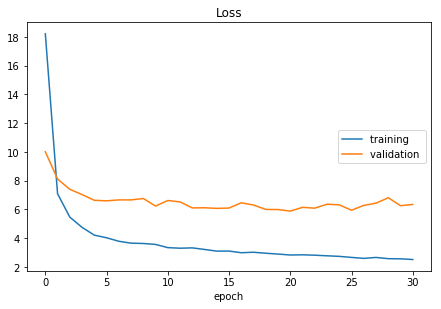

Loss
	training         	 (min:    2.510, max:   35.512, cur:    2.510)
	validation       	 (min:    5.882, max:   31.210, cur:    6.345)
1989/1989 [==============================] - 225s 113ms/step - loss: 2.5101 - val_loss: 6.3449


In [92]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(y6train), validation_steps = len(y6test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [93]:
# # save model
# fname = 'final2 multi ctc mtl gd'
# MODEL_FILE = 'Models/' + fname + '.json' # save path
# WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

# model_json = model.to_json()
# with open(MODEL_FILE, "w") as json_file:
#     json_file.write(model_json)
# model.save_weights(WEIGHT_FILE)

In [94]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    [model.get_layer(name="rd").input, model.get_layer(name="ra").input, model.get_layer(name="image").input], model.get_layer(name="dense2").output
)
# prediction_model.summary()

In [95]:
pred = [np.argmax(np.squeeze(prediction_model.predict(next(predict_generator))),-1) for i in range(len(x11test))]

In [96]:
# best path decoding
pred_labels = []

cnt = 1
for p in pred:
    label = ''
    for num in p:
        if chr(ord('@')+num) == 'T':# or chr(ord('@')+num) == 'A':
            continue
        label = label + chr(ord('@')+num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels)  
print(pred_labels[2])

MMMMMMMMMMAAAAA


In [97]:
for idx in range(len(ctc_ts3)):
#     print(idx)
#     if max(Counter(pred_labels[idx]), key=Counter(pred_labels[idx]).get) != max(Counter(ctc_ts3[idx]), key=Counter(ctc_ts3[idx]).get):
    print(str(idx+1) + '. Predicted: ' + pred_labels[idx] + ' | ' + ctc_ts3[idx] + ' :Original')

1. Predicted: BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBCCCCCCCCCCCCCCCCCCCAAAAAAAAAAAAAAKKKKKKKKKKKKKK | BBBBBBBBBBBBBBBBBCCCCCCCCCCAAAAAAKKKKKKKKKKKKKA :Original
2. Predicted: LLLLLLLLLLA | LLLLLLLLLA :Original
3. Predicted: MMMMMMMMMMAAAAA | MMMMMMMMMAA :Original
4. Predicted: DDDDDDDDDDDDDDDDDDD | DDDDDDDD :Original
5. Predicted: FFFFFFFFFFA | FFFFFFFFFFA :Original
6. Predicted: GGGGGGGGGGAA | GGGGGGGGGGA :Original
7. Predicted: DDDDDDDDDDDDDDDDD | DDDDDDD :Original
8. Predicted: LLLLLLLLLLLA | LLLLLLLLLLA :Original
9. Predicted: MMMMMMMMMAA | MMMMMMMMAAA :Original
10. Predicted: DDDDDDDDDDDDDDDDDDDDDAAAA | DDDDDDDDDAA :Original
11. Predicted: EEEEEEEEEEA | EEEEEEEEEEEA :Original
12. Predicted: FFFFFFFFF | FFFFFFFFF :Original
13. Predicted: GGGGGGGGGGGAAAA | GGGGGGGGGGGAA :Original
14. Predicted: DDDDDDDDDDDDDDDDDDDDDDAAAAAAAAA | DDDDDDDDDDAAAAA :Original
15. Predicted: FFFFFFFFA | FFFFFFFFFF :Original
16. Predicted: GGGGGGGGGGGAA | GGGGGGGGGGA :Original
17. Predicted: DDDDDDDDDDDDDDDDDDD | D

In [98]:
from collections import Counter
mode_orig = [max(Counter(y), key=Counter(y).get) for y in ctc_ts3]
mode_pred = [max(Counter(y), key=Counter(y).get) if len(y) != 0 else 'A' for y in pred_labels]

In [99]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(ctc_ts3)) if len(mode_pred[i]) != 0]
# cmp = ctc_ts4 == pred_labels
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc # was 71 with 8 16 32 64, 77 with 8 16 32 64 64, 74 with 8 16 32 64 64 64

84.25357873210633

In [100]:
# save model
fname = 'revision dbd mti multi ctc mtl gd'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

### 